In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# ==========================================
# 1. SENSE: Load Data (Using GitHub Raw URL)
# ==========================================

# --- PASTE YOUR GITHUB RAW URL BELOW ---
csv_url = 'https://raw.githubusercontent.com/nan06-10/FYP-Sales-15-1-2026/refs/heads/main/restaurant_orders.csv'
# Example: 'https://raw.githubusercontent.com/YourName/Repo/main/restaurant_orders.csv'

try:
    print(f"Attempting to load data from: {csv_url}")
    df = pd.read_csv(csv_url)
    print("SUCCESS: Data loaded from GitHub.")
except Exception as e:
    print("\n!!! ERROR: Could not load data !!!")
    print("1. Make sure you pasted the correct 'Raw' GitHub URL.")
    print("2. Make sure the repository is Public.")
    print(f"Error details: {e}")
    raise

Attempting to load data from: https://raw.githubusercontent.com/nan06-10/FYP-Sales-15-1-2026/refs/heads/main/restaurant_orders.csv
SUCCESS: Data loaded from GitHub.


In [2]:
# ==========================================
# 2. PRE-PROCESS: Prepare Data for AI
# ==========================================
# Convert timestamps
df['Order Time'] = pd.to_datetime(df['Order Time'])
df['Hour'] = df['Order Time'].dt.hour

# Categorize Time
def get_period(h):
    if 6 <= h < 12: return 'Morning'
    elif 12 <= h < 18: return 'Afternoon'
    else: return 'Evening'

df['Time_Period'] = df['Hour'].apply(get_period)

# Define Target: Sales Level
q1 = df['Price'].quantile(0.33)
q2 = df['Price'].quantile(0.66)

def get_level(price):
    if price > q2: return 'High'
    elif price > q1: return 'Medium'
    else: return 'Low'

df['Sales_Level'] = df['Price'].apply(get_level)

# Encode "Category" text into numbers
df['Category_Code'] = df['Category'].astype('category').cat.codes

# ==========================================
# 3. THINK: Train the "Brain"
# ==========================================
# Features: Hour, Quantity, Category
X = df[['Hour', 'Quantity', 'Category_Code']]
y = df['Sales_Level']

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate Accuracy
acc = accuracy_score(y_test, rf_model.predict(X_test))
print(f"\nAI Model Training Complete. Accuracy: {acc*100:.2f}%")


AI Model Training Complete. Accuracy: 44.00%


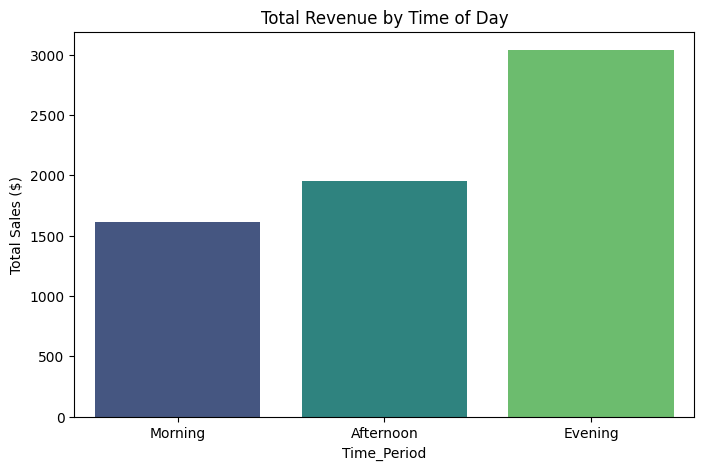

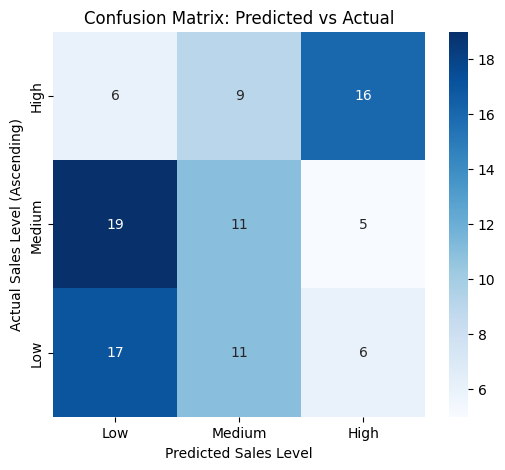

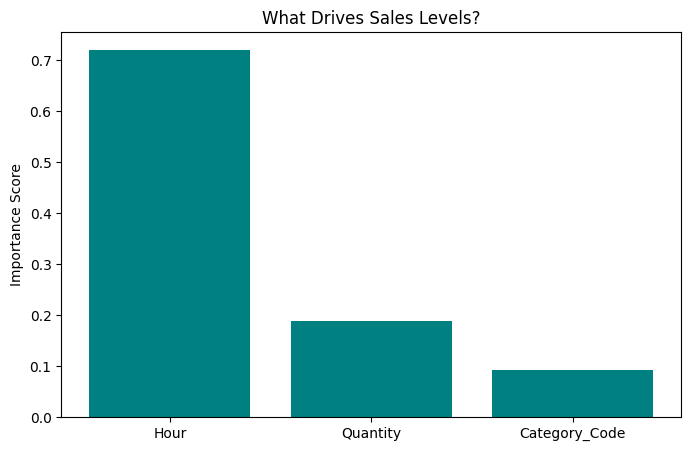

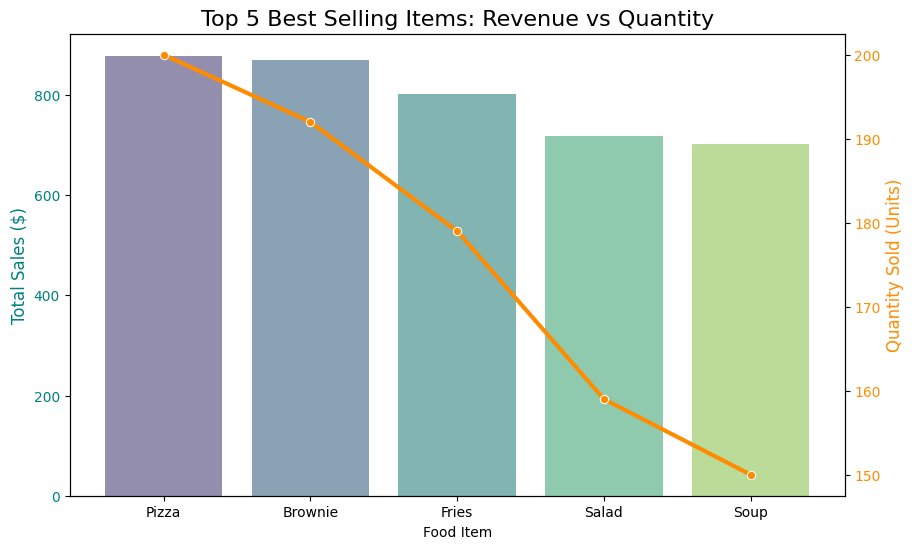

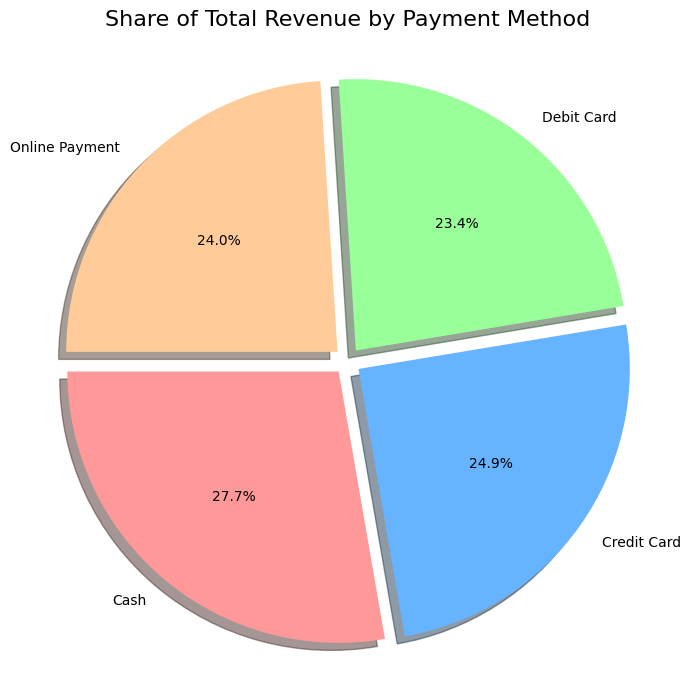

In [4]:
# ==========================================
# 4. ACT: Visualize Results
# ==========================================

# --- CHART 1: Sales Distribution ---
plt.figure(figsize=(8, 5))
sales_by_time = df.groupby('Time_Period')['Price'].sum().reset_index()
sales_by_time['Time_Period'] = pd.Categorical(
    sales_by_time['Time_Period'], categories=['Morning', 'Afternoon', 'Evening'], ordered=True
)
sales_by_time = sales_by_time.sort_values('Time_Period')


sns.barplot(data=sales_by_time, x='Time_Period', y='Price', palette='viridis', hue='Time_Period', legend=False)
plt.title('Total Revenue by Time of Day')
plt.ylabel('Total Sales ($)')
plt.show()

# --- CHART 2: Confusion Matrix (Fixed) ---
y_pred = rf_model.predict(X_test)
labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_flipped = np.flipud(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_flipped, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['High', 'Medium', 'Low'])
plt.title('Confusion Matrix: Predicted vs Actual')
plt.ylabel('Actual Sales Level (Ascending)')
plt.xlabel('Predicted Sales Level')
plt.show()

# --- CHART 3: Feature Importance ---
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = ['Hour', 'Quantity', 'Category_Code']

plt.figure(figsize=(8, 5))
plt.title("What Drives Sales Levels?")
plt.bar(range(len(features)), importances[indices], align="center", color='teal')
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.ylabel("Importance Score")
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# Top 5 Food Items (Sales & Quantity)
# ==========================================
food_stats = df.groupby('Food Item').agg({
    'Price': 'sum',      # Total Sales
    'Quantity': 'sum'    # Total Quantity
}).reset_index()

# Sort to find the Top 5 best sellers
top_5 = food_stats.sort_values('Price', ascending=False).head(5)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Axis: Sales (Bar Chart)
sns.barplot(data=top_5, x='Food Item', y='Price', ax=ax1, palette='viridis', hue='Food Item', legend=False, alpha=0.6)
ax1.set_ylabel('Total Sales ($)', color='teal', fontsize=12)
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_title('Top 5 Best Selling Items: Revenue vs Quantity', fontsize=16)

# Secondary Axis: Quantity (Line Chart)
ax2 = ax1.twinx()
sns.lineplot(data=top_5, x='Food Item', y='Quantity', ax=ax2, color='darkorange', marker='o', linewidth=3)
ax2.set_ylabel('Quantity Sold (Units)', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.show()


# ==========================================
# VIZ: Payment Method Share (Adjusted Position)
# ==========================================
payment_stats = df.groupby('Payment Method')['Price'].sum().reset_index()

plt.figure(figsize=(8, 8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

plt.pie(payment_stats['Price'],
        labels=payment_stats['Payment Method'],
        autopct='%1.1f%%',
        startangle=180,        # CHANGED: Rotates chart to move Online Payment left
        colors=colors,
        shadow=True,
        explode=[0.05]*len(payment_stats))

# Added 'pad=20' to push the title slightly higher up for more breathing room
plt.title('Share of Total Revenue by Payment Method', fontsize=16, pad=20)
plt.axis('equal')
plt.show()